In [23]:
import gc
from typing import List

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML, display

from sklearn.datasets import fetch_covtype
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.optim import Optimizer
from torch.autograd import Function
import torch.utils.benchmark as benchmark
import torch._dynamo
import torch._inductor.metrics as metrics

from torchinfo import summary

In [24]:
import time

def benchmark(model, x, y, optimizer, loss_fn, iterations, device):
    forward_times = []
    backward_times = []

    for _ in range(5):
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

    if device == 'cuda':
        torch.cuda.synchronize()

    for i in range(iterations):
        optimizer.zero_grad()

        start_time = time.perf_counter()
        output = model(x)
        if device == 'cuda':
            torch.cuda.synchronize()
        end_time = time.perf_counter()
        forward_times.append(end_time - start_time)

        loss = loss_fn(output, y)

        start_time = time.perf_counter()
        loss.backward()
        if device == 'cuda':
            torch.cuda.synchronize()
        end_time = time.perf_counter()
        backward_times.append(end_time - start_time)

        optimizer.step()

    avg_forward = sum(forward_times) / iterations * 1000
    avg_backward = sum(backward_times) / iterations * 1000

    print("-" * 50)
    print(f"Benchmarking Results on '{device.upper()}'")
    print(f"Iterations: {iterations}")
    print(f"Average Forward Pass Time:  {avg_forward:.4f} ms")
    print(f"Average Backward Pass Time: {avg_backward:.4f} ms")
    print("-" * 50)

In [30]:
BATCH_SIZE = 1000
NUM_FEATURES = 100
NUM_CONTROL_POINTS = 1000
ITERATIONS = 100
LEARNING_RATE = 1e-3
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'mps'

print(f"Using device: {DEVICE}")

x_input = torch.randn(BATCH_SIZE, NUM_FEATURES).to(DEVICE)
y_target = torch.randn(BATCH_SIZE, NUM_FEATURES).to(DEVICE)

Using device: mps


In [56]:
class CustomActivationEfficient(nn.Module):
    def __init__(self, num_features, num_control_points=1000, eps=1e-6):
        super(CustomActivationEfficient, self).__init__()
        self.register_buffer("mins", None)
        self.register_buffer("maxs", None)

        self.eps = eps
        self.num_control_points = num_control_points

        self.r_weight = nn.Parameter(torch.zeros(num_features, num_control_points))  # (num_features, num_control_points)
        self.l_weight = nn.Parameter(torch.zeros(num_features, num_control_points))  # (num_features, num_control_points)

        self.register_buffer("local_bias", torch.arange(num_control_points))  # (num_control_points,)
        self.register_buffer("feature_offset", torch.arange(num_features).view(1, -1) * self.num_control_points)  # (1, num_features)

    def forward(self, x):
        # x: (batch_size, num_features)

        if self.training or self.mins is None or self.maxs is None:
            self.mins = x.amin(dim=0, keepdim=True)  # (1, num_features)
            self.maxs = x.amax(dim=0, keepdim=True)  # (1, num_features)

        x = (x - self.mins) / (self.maxs - self.mins + self.eps) * (self.num_control_points - 1)  # (batch_size, num_features)

        # TODO: may change to feature-major order (num_features, batch_size) since that may help with memory access patterns (improved locality)
        
        lower_indices_float = x.floor().clamp(0, self.num_control_points - 2)  # (batch_size, num_features)
        lower_indices = lower_indices_float.long() + self.feature_offset  # (batch_size, num_features)

        indices = torch.stack((lower_indices, lower_indices + 1), dim=-1)  # (batch_size, num_features, 2)
        vals = F.embedding(indices, self.get_interp_tensor())  # (batch_size, num_features, 2, 1)

        lower_val, upper_val = vals.squeeze(-1).unbind(-1)  # each: (batch_size, num_features)
        return torch.lerp(lower_val, upper_val, x - lower_indices_float)  # (batch_size, num_features)
    
    def get_interp_tensor(self):
        cs_r_weight = torch.cumsum(self.r_weight, dim=1)  # (num_features, num_control_points)
        cs_l_weight = torch.cumsum(self.l_weight, dim=1)  # (num_features, num_control_points)

        cs_r_weight_bias_prod = torch.cumsum(self.r_weight * self.local_bias, dim=1)  # type: ignore (num_features, num_control_points)
        cs_l_weight_bias_prod = torch.cumsum(self.l_weight * self.local_bias, dim=1)  # type: ignore (num_features, num_control_points)

        r_interp = (self.local_bias * cs_r_weight - cs_r_weight_bias_prod)  # type: ignore (num_features, num_control_points)
        l_interp = (cs_l_weight_bias_prod[..., -1:] - cs_l_weight_bias_prod) - self.local_bias * (cs_l_weight[..., -1:] - cs_l_weight)  # type: ignore (num_features, num_control_points)
        return (r_interp + l_interp).view(-1, 1)  # (num_features * num_control_points, 1)
        

In [69]:
class CustomActivationNaive(nn.Module):
    def __init__(self, num_features, num_control_points=1000, eps=1e-6):
        super(CustomActivationNaive, self).__init__()
        self.register_buffer("mins", None)
        self.register_buffer("maxs", None)

        self.num_control_points = num_control_points
        self.eps = eps
        
        self.register_buffer("local_bias", torch.arange(num_control_points))  # (num_control_points,)

        self.pos_weight = nn.Parameter(torch.zeros(num_features, num_control_points))
        self.neg_weight = nn.Parameter(torch.zeros(num_features, num_control_points))

    def forward(self, x):
        if self.training or self.mins is None or self.maxs is None:
            self.mins = x.amin(dim=0, keepdim=True)  # (1, num_features)
            self.maxs = x.amax(dim=0, keepdim=True)  # (1, num_features)

        x = (x - self.mins) / (self.maxs - self.mins + self.eps) * (self.num_control_points - 1)  # (batch_size, num_features)
        x_shifted = x.unsqueeze(-1) - self.local_bias.view(1, 1, -1)
        a =  (F.relu(x_shifted) * self.pos_weight).sum(dim=-1) + (F.relu(-x_shifted) * self.neg_weight).sum(dim=-1)
        return a

In [34]:
model = torch.compile(CustomActivationEfficient(
    num_features=NUM_FEATURES,
    num_control_points=NUM_CONTROL_POINTS
).to(DEVICE), backend='aot_eager')
model.train()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

benchmark(model, x_input, y_target, optimizer, loss_function, ITERATIONS, DEVICE)

--------------------------------------------------
Benchmarking Results on 'MPS'
Iterations: 100
Average Forward Pass Time:  0.9990 ms
Average Backward Pass Time: 1.0678 ms
--------------------------------------------------


In [35]:
model = torch.compile(CustomActivationNaive(
    num_features=NUM_FEATURES,
    num_control_points=NUM_CONTROL_POINTS
).to(DEVICE), backend='aot_eager')
model.train()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

benchmark(model, x_input, y_target, optimizer, loss_function, ITERATIONS, DEVICE)

--------------------------------------------------
Benchmarking Results on 'MPS'
Iterations: 100
Average Forward Pass Time:  58.6110 ms
Average Backward Pass Time: 63.2349 ms
--------------------------------------------------


In [36]:
torch._dynamo.config.cache_size_limit = 16

device = torch.device("cuda")
device = torch.device("cpu")
device = torch.device("mps")

In [55]:
df = sns.load_dataset('diamonds')
df = df[['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut']]

X = df.drop(['carat', 'depth', 'table', 'price', 'y', 'z', 'cut'], axis=1)
y = df['price']

x_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = x_scaler.fit_transform(X)

y_scaler = MinMaxScaler(feature_range=(-5, 5))
y = y_scaler.fit_transform(y.to_numpy().reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device).view(-1, 1)

print(X.shape)
print(y.shape)

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

(53940, 1)
(53940, 1)
X_train_tensor shape: torch.Size([43152, 1])
y_train_tensor shape: torch.Size([43152, 1])
X_test_tensor shape: torch.Size([10788, 1])
y_test_tensor shape: torch.Size([10788, 1])


In [40]:
def train(
    model,
    criterion,
    optimizers: List[torch.optim.Optimizer],
    epochs: int,
    *,
    plot_every: int = 50,
    anim_interval_ms: int = 500,
    warmup_epochs = 100
):
    # print(summary(model, input_data=X_train_tensor))  # type: ignore[arg-type]
    
    plt.rcParams['animation.embed_limit'] = 50

    # torch.set_printoptions(threshold=float("inf"))
    # for name, param in model.named_parameters():
    #     print(name)
    #     print(param)

    best_test_loss = float("inf")
    train_losses: list[float] = []
    test_losses: list[float] = []
    learning_rates: list[float] = []

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    schedulers = [
        torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, factor=0.999, patience=0, threshold=0, eps=0
        )
        for opt in optimizers
    ]

    frames: list[np.ndarray] = []

    for epoch in range(1, epochs + 1):
        if epoch <= warmup_epochs:
            warmup_scale = epoch / warmup_epochs
            for opt in optimizers:
                for group in opt.param_groups:
                    group["lr"] = group.get("base_lr", group["lr"]) * warmup_scale

        model.train()
        for opt in optimizers:
            opt.zero_grad()

        train_outputs = model(X_train_tensor)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_predictions = torch.argmax(test_outputs, dim=1)
            test_accuracy = (
                (test_predictions == y_test_tensor).sum().item() / y_test_tensor.size(0)
            )

        train_loss = criterion(train_outputs, y_train_tensor)
        train_loss.backward()

        for opt in optimizers:
            opt.step()

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        learning_rates.append(schedulers[0].optimizer.param_groups[0]["lr"])

        if test_loss.item() < best_test_loss:
            best_test_loss = test_loss.item()

        if epoch > warmup_epochs:
            for sched in schedulers:
                sched.step(train_loss.item())

        if epoch % 1 == 0:
            print(
                f"Epoch {epoch}/{epochs}, "
                f"Train Loss: {train_loss.item():.6f}, "
                f"Test Loss: {test_loss.item():.6f}, "
                f"Test Acc: {test_accuracy:.4f}, "
                f"LR: {schedulers[0].optimizer.param_groups[0]['lr']:.4e}"
            )

        if epoch % plot_every == 0 or epoch == epochs:
            fig, axes = plt.subplots(3, 1, figsize=(12, 18), constrained_layout=True)

            axes[0].plot(train_losses, label="Train Loss")
            axes[0].plot(test_losses, label="Test Loss")
            axes[0].set_title("Loss vs. Epoch")
            axes[0].set_xlabel("Epoch")
            axes[0].set_ylabel("Cross-entropy loss")
            axes[0].grid(True)
            axes[0].legend()

            axes[1].plot(learning_rates, label="LR", color="green")
            axes[1].set_title("Learning-rate trajectory")
            axes[1].set_xlabel("Epoch")
            axes[1].set_ylabel("Learning rate")
            axes[1].grid(True)
            axes[1].legend()

            model.eval()

            X_plot = torch.linspace(-1, 1, 20000).reshape(-1, 1).to(device)
            with torch.no_grad():
                model_output = model(X_plot)

            axes[2].plot(
                X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy(), "b.", label="y_train"
            )
            axes[2].plot(
                X_plot.cpu().numpy(), model_output.detach().cpu().numpy(), "r.", label="model(X)"
            )
            axes[2].set_title("Model output vs. target")
            axes[2].set_xlabel("X")
            axes[2].grid(True)
            axes[2].legend()

            fig.canvas.draw()
            width, height = fig.canvas.get_width_height()
            buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(
                height, width, 4
            )
            frame = buf[:, :, :3].copy()
            frames.append(frame)
            plt.close(fig)

    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print(
            f"[GPU] Peak memory allocated: "
            f"{torch.cuda.max_memory_allocated() / 1024 ** 2:.2f} MB"
        )
        print(
            f"[GPU] Peak memory reserved: "
            f"{torch.cuda.max_memory_reserved() / 1024 ** 2:.2f} MB"
        )

    if frames:
        fig_anim = plt.figure(figsize=(8, 6))
        im = plt.imshow(frames[0])
        plt.axis("off")

        def _animate(i):
            im.set_data(frames[i])
            return [im]

        ani = animation.FuncAnimation(
            fig_anim,
            _animate,
            frames=len(frames),
            interval=anim_interval_ms,
            blit=True,
        )
        display(HTML(ani.to_jshtml()))

    print("Best test loss:", best_test_loss)

    print()
    torch.set_printoptions(sci_mode=False)
    for name, param in model.named_parameters(): # type: ignore
        print(name)
        print(param)

In [65]:
model = (CustomActivationEfficient(num_features=1, num_control_points=10000).to(device))

criterion = nn.MSELoss()

common_factor = 1e-5
optimizers = [optim.AdamW(model.parameters(), lr=0.001 * common_factor, weight_decay=0.0)] # type: ignore

for opt in optimizers:
    for g in opt.param_groups:
        g.setdefault("base_lr", g["lr"])

train(model, criterion, optimizers, epochs=1000, warmup_epochs=10, plot_every=10) # type: ignore

Epoch 1/1000, Train Loss: 13.933830, Test Loss: 14.037660, Test Acc: 0.0000, LR: 1.0000e-09
Epoch 2/1000, Train Loss: 13.779582, Test Loss: 13.882418, Test Acc: 0.0000, LR: 2.0000e-09
Epoch 3/1000, Train Loss: 13.475119, Test Loss: 13.575974, Test Acc: 0.0000, LR: 3.0000e-09
Epoch 4/1000, Train Loss: 13.028653, Test Loss: 13.126540, Test Acc: 0.0000, LR: 4.0000e-09
Epoch 5/1000, Train Loss: 12.452649, Test Loss: 12.546593, Test Acc: 0.0000, LR: 5.0000e-09
Epoch 6/1000, Train Loss: 11.763851, Test Loss: 11.852891, Test Acc: 0.0000, LR: 6.0000e-09
Epoch 7/1000, Train Loss: 10.983171, Test Loss: 11.066373, Test Acc: 0.0000, LR: 7.0000e-09
Epoch 8/1000, Train Loss: 10.135409, Test Loss: 10.211873, Test Acc: 0.0000, LR: 8.0000e-09
Epoch 9/1000, Train Loss: 9.248706, Test Loss: 9.317581, Test Acc: 0.0000, LR: 9.0000e-09
Epoch 10/1000, Train Loss: 8.353673, Test Loss: 8.414169, Test Acc: 0.0000, LR: 1.0000e-08
Epoch 11/1000, Train Loss: 7.482110, Test Loss: 7.533519, Test Acc: 0.0000, LR: 1.0

KeyboardInterrupt: 

In [ ]:
class CustomActivation(nn.Module):
    def __init__(self, num_features, num_control_points):
        super(CustomActivation, self).__init__()
        # self.register_buffer('local_bias', torch.linspace(1, num_control_points * 2 - 1, num_control_points).expand(num_features, -1))
        self.register_buffer('local_bias', torch.linspace(-5, 5, num_control_points).expand(num_features, -1))

        self.pos_weight = nn.Parameter(torch.zeros(num_features, num_control_points))
        self.neg_weight = nn.Parameter(torch.zeros(num_features, num_control_points))

        self.global_weight = nn.Parameter(torch.zeros(1, num_features))
        self.global_bias = nn.Parameter(torch.zeros(1, num_features))

        self.x_nonlinear_mean = None

    def forward(self, x):
        x_shifted = x.unsqueeze(-1) + self.local_bias
        x_nonlinear = (F.relu(x_shifted) * self.pos_weight).sum(dim=-1) + (F.relu(-x_shifted) * self.neg_weight).sum(dim=-1)

        if self.training or self.x_nonlinear_mean is None:
            self.x_nonlinear_mean = x_nonlinear.mean(dim=0, keepdim=True)

        return x_nonlinear - self.x_nonlinear_mean + self.global_bias * 100 # Center the output around zero

    def compute_l2_penalty(self):
        return 0

Epoch 1/10, Train Loss: 13.933830, Test Loss: 14.037660, Test Acc: 0.0000, LR: 1.0000e-02
Epoch 2/10, Train Loss: 9.497614, Test Loss: 9.573133, Test Acc: 0.0000, LR: 1.0000e-02
Epoch 3/10, Train Loss: 6.863405, Test Loss: 6.909505, Test Acc: 0.0000, LR: 1.0000e-02
Epoch 4/10, Train Loss: 5.893723, Test Loss: 5.910882, Test Acc: 0.0000, LR: 1.0000e-02
Epoch 5/10, Train Loss: 6.175926, Test Loss: 6.167316, Test Acc: 0.0000, LR: 9.9900e-03
Epoch 6/10, Train Loss: 7.008674, Test Loss: 6.980675, Test Acc: 0.0000, LR: 9.9800e-03
Epoch 7/10, Train Loss: 7.695856, Test Loss: 7.656814, Test Acc: 0.0000, LR: 9.9700e-03
Epoch 8/10, Train Loss: 7.895561, Test Loss: 7.853590, Test Acc: 0.0000, LR: 9.9601e-03
Epoch 9/10, Train Loss: 7.628235, Test Loss: 7.589876, Test Acc: 0.0000, LR: 9.9501e-03
Epoch 10/10, Train Loss: 7.090484, Test Loss: 7.060397, Test Acc: 0.0000, LR: 9.9401e-03


Best test loss: 5.910881519317627

pos_weight
Parameter containing:
tensor([[-0.0310, -0.0339, -0.0360, -0.0375, -0.0387, -0.0396, -0.0404, -0.0410,
         -0.0415, -0.0420]], device='mps:0', requires_grad=True)
neg_weight
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='mps:0',
       requires_grad=True)


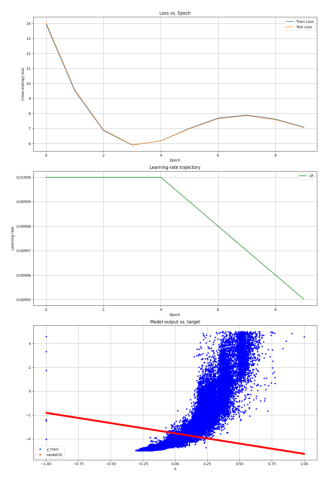

In [74]:
model = (CustomActivation(num_features=1, num_control_points=10).to(device))

criterion = nn.MSELoss()

common_factor = 10.0
optimizers = [optim.AdamW(model.parameters(), lr=0.001 * common_factor, weight_decay=0.0)] # type: ignore

for opt in optimizers:
    for g in opt.param_groups:
        g.setdefault("base_lr", g["lr"])

train(model, criterion, optimizers, epochs=10, warmup_epochs=0, plot_every=1) # type: ignore

In [62]:
model = torch.compile((CustomActivationNaive(num_features=1, num_control_points=10000).to(device)), backend='aot_eager')

criterion = nn.MSELoss()

common_factor = 1e-5
optimizers = [optim.AdamW(model.parameters(), lr=0.001 * common_factor, weight_decay=0.0)] # type: ignore

for opt in optimizers:
    for g in opt.param_groups:
        g.setdefault("base_lr", g["lr"])

train(model, criterion, optimizers, epochs=100, warmup_epochs=10, plot_every=1) # type: ignore

Epoch 1/100, Train Loss: 13.933830, Test Loss: 14.037660, Test Acc: 0.0000, LR: 1.0000e-09
Epoch 2/100, Train Loss: 13.354610, Test Loss: 13.455394, Test Acc: 0.0000, LR: 2.0000e-09
Epoch 3/100, Train Loss: 12.262135, Test Loss: 12.356758, Test Acc: 0.0000, LR: 3.0000e-09
Epoch 4/100, Train Loss: 10.790510, Test Loss: 10.875748, Test Acc: 0.0000, LR: 4.0000e-09
Epoch 5/100, Train Loss: 9.141768, Test Loss: 9.214271, Test Acc: 0.0000, LR: 5.0000e-09
Epoch 6/100, Train Loss: 7.578231, Test Loss: 7.634599, Test Acc: 0.0000, LR: 6.0000e-09
Epoch 7/100, Train Loss: 6.398024, Test Loss: 6.435009, Test Acc: 0.0000, LR: 7.0000e-09
Epoch 8/100, Train Loss: 5.878324, Test Loss: 5.893263, Test Acc: 0.0000, LR: 8.0000e-09
Epoch 9/100, Train Loss: 6.172731, Test Loss: 6.164283, Test Acc: 0.0000, LR: 9.0000e-09
Epoch 10/100, Train Loss: 7.183979, Test Loss: 7.153039, Test Acc: 0.0000, LR: 1.0000e-08
Epoch 11/100, Train Loss: 8.512949, Test Loss: 8.463303, Test Acc: 0.0000, LR: 1.0000e-08
Epoch 12/10

KeyboardInterrupt: 

In [54]:
for name, param in model.named_parameters(): # type: ignore
    print(name)
    print(param)

pos_weight
Parameter containing:
tensor([[    -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
     